In [29]:
%load_ext autoreload
%autoreload 2
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from unet import Unet
from diffusion import GaussianDiffusion, DiffusionImageAPI
from train import ImageDataset

model = Unet(
  image_channels=3,
)

model.load_state_dict(torch.load("model.pt"))

diffusion = GaussianDiffusion(
  model=model,
  #noise_steps=256,
  noise_steps=1024,
  beta_0=1e-4,
  beta_T=0.02,
  #image_size=(120, 80),
  image_size=(80, 120),
  #image_size=(16, 16),
)

imageAPI = DiffusionImageAPI(diffusion)

dataset = ImageDataset()

dataloader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=False,
)

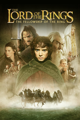

In [31]:
imageAPI.tensor_to_image(
  dataset[0]
)

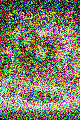

In [55]:
normalized_image = diffusion.normalize_image(dataset[0])
max_noise_image = diffusion.apply_noise(
  normalized_image.unsqueeze(0), 
  torch.tensor([300])
)
imageAPI.tensor_to_image(diffusion.denormalize_image(max_noise_image[0]))


In [33]:
max_noise_image.shape

torch.Size([1, 120, 80, 3])

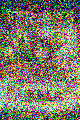

In [51]:
t = 300
denoised_image = model(max_noise_image, torch.tensor([t])).detach()
x = max_noise_image 
alpha = diffusion.alphas[t]
alpha_hat = diffusion.alpha_hat[t]
beta = diffusion.betas[t]
z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
x = 1 / torch.sqrt(alpha) * (x - (beta / alpha_hat) * denoised_image)# + torch.sqrt(beta) * z 
denoised_image = x
imageAPI.tensor_to_image(diffusion.denormalize_image(denoised_image[0]))

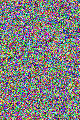

In [54]:
x = max_noise_image 
for t in range(300, 0, -1):
  denoised_image = model(max_noise_image, torch.tensor([t]))
  alpha = diffusion.alphas[t]
  alpha_hat = diffusion.alpha_hat[t]
  beta = diffusion.betas[t]
  z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
  x = 1 / torch.sqrt(alpha) * (x - (beta / alpha_hat) * denoised_image) + torch.sqrt(beta) * z 

denoised_image = x
imageAPI.tensor_to_image(diffusion.denormalize_image(denoised_image.detach()[0]))